## Building a Recommendation Engine using ML Algorithms & GenAI RAG Embeddings

A Comprehensive Guide to build a Recommendation Engine using ML models.

**Author:** Amit Shukla

---

A movie aficionado can predict what they'll want to watch next, a savvy shopper knows what and how much to buy, a skilled caterer can forecast food demand, and a talented barista can anticipate orders. Despite these individual skills, companies like Netflix and Amazon still develop recommendation systems.

My fictional friend who owns a restaurant challenged me to create an AI that could match his expertise. 
I used techniques inspired by Amazon and Netflix to build a recommendation AI.

I'm sharing the details of my work in this notebook.

---

**The goal of a Caterer Recommendation System** AI is to suggest items that are tailored to a customer's tastes and preferences, much like a personalized menu for a family or individual.

`TL;DR = The AI aims to provide -`

| Prediction      | Accuracy |
| ----------- | ----------- |
| an optimal list of dishes that complement each other | **0.7995** |
| an optimal list of dishes that cater to the customer's culinary preferences | **0.83055** |
| AI can help identify the recipes quantity and deviation | - |


*Part-1 notebook is created using artificial, opinionated data to easily understand and test this AI system based on intuition. Goal is to apply this learning to Part-2 data set.*

`Recommendation systems` use popularity, collaborative filtering, content-based filtering, or a hybrid of both to predict user interests.

**Approach 1: Popularity** is simply a list of most consumed items by certain criteria, such as meal time or group of customers.

**Approach 2: Content-based filtering (GenAI Embeddings)** uses item attributes to recommend similar items.

**Approach 3: Collaborative filtering** assumes that users with similar preferences to a user will have similar interests.

**Approach 4: Hybrid methods** combine both to improve recommendations and overcome problems like cold start and sparsity.


---

## Table of Content

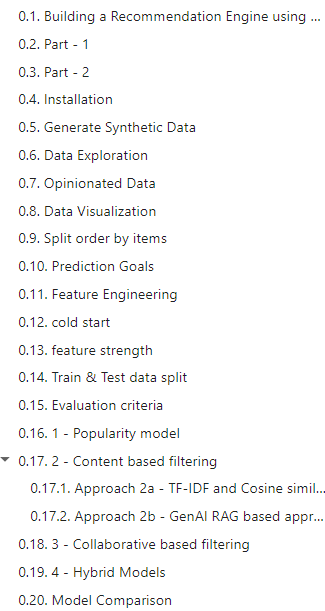

## Installation

In [ ]:
# !pip install jax jaxlib Pandas matplotlib seaborn scikit-learn faker nltk
# JAX is chosen ML framework instead of PyTorch because given data doesn't need much of traditional Deep learning algo
# still, data is huge and lots of fast numpy calculation will be required
# JAX is supported on Databricks environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from faker import Faker
from faker.providers import DynamicProvider

## Generate Synthetic Data

In [2]:
# generate a fake list of 8 Food Items in each category
# category = [starter, specials, maincourse]
food = ['Carbonara Arancini',
'Chopped Italian Salad',
'Pan-fried Scamorza with Arugula Salad',
'Bruschetta of Spring Vegetables',
'Bruschetta with Pickled Okra',
'White-bean and Prosciutto Bruschetta',
'Ricotta and Roasted Tomato Bruschetta with Pancetta',
'Autumn Fritto Misto',
'Spaghetti alla Carbonara',
'Napoletana Pizza',
'Risotto',
'Fiorentina Steak',
'Polenta',
'Truffles',
'Lasagne',
'Gelato'  ,  
'Aperitivo',
'Antipasti',
'Primi',
'Secondi',
'Contorni',
'Insalata',
'Formaggi e frutta',
'Dolce'
]

foodList = pd.DataFrame({
    "itemID":  list(range(1000, 1024, 1)),
    "category": ["starter"]*8 + ["specials"]*8+["maincourse"]*8,
    "item": food
})
# foodList.loc[foodList["category"] == "starter"]
print(foodList.groupby("category").count())
foodList.sample(5)

            itemID  item
category                
maincourse       8     8
specials         8     8
starter          8     8


,itemID,category,item
13,1013,specials,Truffles
8,1008,specials,Spaghetti alla Carbonara
16,1016,maincourse,Aperitivo
5,1005,starter,White-bean and Prosciutto Bruschetta
2,1002,starter,Pan-fried Scamorza with Arugula Salad


In [3]:
# print all starters
foodList.loc[foodList["category"] == "starter"]

,itemID,category,item
0,1000,starter,Carbonara Arancini
1,1001,starter,Chopped Italian Salad
2,1002,starter,Pan-fried Scamorza with Arugula Salad
3,1003,starter,Bruschetta of Spring Vegetables
4,1004,starter,Bruschetta with Pickled Okra
5,1005,starter,White-bean and Prosciutto Bruschetta
6,1006,starter,Ricotta and Roasted Tomato Bruschetta with Pan...
7,1007,starter,Autumn Fritto Misto


In [4]:
# adding fake data providers
# this code will generate fake synthetic data in each category such as
# customer name, category, race, accompanying guests, meal type

from faker import Faker
from faker.providers import DynamicProvider
fake = Faker()
fake.seed_instance(4321)

customerCategory = ["personal", "business", "party", "casual", "others"]
race = ["non-italian", "italian"]
guests = [1, 2, 4, 6, 10]
meal = ["lunch", "dinner", "mid-day"]
weekDayType = [True, False] # 0 = true, 1 = false = weekend
holidayType = [True, False] # 0 = true, 1 = false
customerCategory_provider = DynamicProvider(
     provider_name="customerCategory",
     elements=customerCategory,
)
race_provider = DynamicProvider(
     provider_name="raceCategory",
     elements=race,
)
meal_provider = DynamicProvider(
     provider_name="mealCategory",
     elements=meal,
)
starter_provider = DynamicProvider(
     provider_name="starterMeal",
     elements=foodList.loc[foodList["category"] == "starter"].itemID.tolist(),
)
specials_provider = DynamicProvider(
     provider_name="specialsMeal",
     elements=foodList.loc[foodList["category"] == "specials"].itemID.tolist(),
)
maincourse_provider = DynamicProvider(
     provider_name="maincourseMeal",
     elements=foodList.loc[foodList["category"] == "maincourse"].itemID.tolist(),
)
# add new provider to faker instance
fake.add_provider(customerCategory_provider)
fake.add_provider(race_provider)
fake.add_provider(meal_provider)
fake.add_provider(starter_provider)
fake.add_provider(specials_provider)
fake.add_provider(maincourse_provider)

# now you can use:
fake.maincourseMeal()
# 'casual'

1019

In [5]:
# create fake transactions (random)
import random
from random import shuffle

sampleSize = 10000 # create 100K random customer visits
# let's assume, one guest (with 0 accompanying) walks into restaurant

# customer_name	race	guests	datatime	weekend	daytime	customercategory	catering location	food	qty	price	tip

# create sampleSize number of customers
name = []
custType = []
race = []
meal = []
starter = []
specials = []
maincourse = []
weekday = []
holiday = []
for _ in range(sampleSize):
    name.append(fake.name())
    custType.append(fake.customerCategory())
    race.append(fake.raceCategory())
    meal.append(fake.mealCategory())
    starter.append(fake.starterMeal())
    specials.append(fake.specialsMeal())
    maincourse.append(fake.maincourseMeal())
    weekday.append(random.choice(weekDayType))
    holiday.append(random.choice(holidayType))
    
    ##############################################
    # this code below is used to get rid of dups
    # we want to keep duplicates, hence commented
    ##############################################    
    # if n in name:
    #     name.append("Repeat")
    # else:
    #     name.append(n)

sales = pd.DataFrame({
    'name': name,
    'customerType': custType,
    'race': race,
    'meal':meal,
    'weekday':weekday,
    'holiday':holiday,
    'starter':starter,
    'specials':specials,
    'maincourse':maincourse
})
sales.shape

(10000, 9)

## Data Exploration

In [6]:
print(sales.shape) # show size of dataframe
sales.head(5) # print top 5 rows

df1 = foodList.loc[foodList["category"] == "starter"].rename(columns={"itemID": "starter", "item": "starter_desc"}, errors="raise")[["starter","starter_desc"]]
df2 = foodList.loc[foodList["category"] == "specials"].rename(columns={"itemID": "specials", "item": "specials_desc"}, errors="raise")[["specials","specials_desc"]]
df3 = foodList.loc[foodList["category"] == "maincourse"].rename(columns={"itemID": "maincourse", "item": "maincourse_desc"}, errors="raise")[["maincourse","maincourse_desc"]]
dfSales = sales.merge(df1, how='outer').merge(df2, how='outer').merge(df3, how='outer')
dfSales.sample(5) # print 5 sample rows

(10000, 9)


,name,customerType,race,meal,weekday,holiday,starter,specials,maincourse,starter_desc,specials_desc,maincourse_desc
8772,James Vega,others,non-italian,lunch,False,True,1006,1015,1022,Ricotta and Roasted Tomato Bruschetta with Pan...,Gelato,Formaggi e frutta
5266,Lisa Harris,business,non-italian,mid-day,True,True,1004,1009,1020,Bruschetta with Pickled Okra,Napoletana Pizza,Contorni
3600,Javier Johnson,others,non-italian,mid-day,True,False,1004,1014,1018,Bruschetta with Pickled Okra,Lasagne,Primi
7946,Lisa Hill,personal,italian,mid-day,True,True,1003,1010,1022,Bruschetta of Spring Vegetables,Risotto,Formaggi e frutta
4835,Michael Johnson,party,italian,dinner,True,True,1007,1014,1019,Autumn Fritto Misto,Lasagne,Secondi


In [7]:
########################################################
# we will work only on numbers
# use only two fields for easy ML
# guest Type and order = starter + specials + maincourse
########################################################
# let's convert all text to numbers
# these numbers are 100% join-able with look-up tables
# be careful when converting to number, try to make it equal digits category for easy parsing
# for example, use 01, if there are more than 10 categories in a field

# dfSales['customerType_i'] = dfSales['customerType'].apply(lambda x: customerCategory.index(x)) # store index value

dfSales['guest'] = (dfSales['customerType'].apply(lambda x: customerCategory.index(x)).astype(str) 
                        + dfSales['race'].apply(lambda x: race.index(x)).astype(str) 
                        + dfSales['meal'].apply(lambda x: meal.index(x)).astype(str) 
                        + dfSales['weekday'].apply(lambda x: weekday.index(x)).astype(str)
                        + dfSales['holiday'].apply(lambda x: holiday.index(x)).astype(str))
# dfSales['order'] = (dfSales['starter'].astype(str) 
#                         + dfSales['specials'].astype(str) 
#                         + dfSales['maincourse'].astype(str))
# dfSales['order'] = dfSales['holiday'].apply(lambda x: holidayType.index(x)) # store index value
dfSales['order'] = dfSales[['starter', 'specials', 'maincourse']].values.tolist()
dfSales[["guest","order"]].shape

(10000, 2)

In [9]:
dfSales.tail(5)

,name,customerType,race,meal,weekday,holiday,starter,specials,maincourse,starter_desc,specials_desc,maincourse_desc,guest,order
9995,Ryan Marsh,party,non-italian,mid-day,True,False,1007,1015,1023,Autumn Fritto Misto,Gelato,Dolce,22400,"[1007, 1015, 1023]"
9996,Amanda Weber,others,non-italian,mid-day,True,True,1007,1015,1023,Autumn Fritto Misto,Gelato,Dolce,42402,"[1007, 1015, 1023]"
9997,Jillian Bird,others,italian,lunch,False,True,1007,1015,1023,Autumn Fritto Misto,Gelato,Dolce,40232,"[1007, 1015, 1023]"
9998,Alex Cunningham,personal,non-italian,dinner,True,False,1007,1015,1023,Autumn Fritto Misto,Gelato,Dolce,02000,"[1007, 1015, 1023]"
9999,Brandon Gordon,party,italian,lunch,True,True,1007,1015,1023,Autumn Fritto Misto,Gelato,Dolce,20202,"[1007, 1015, 1023]"


In [10]:
# a true numerical data for ML training
dfSales[["guest","order"]].shape, dfSales[["guest","order"]].sample(5)

((10000, 2),
       guest               order
 9200  42402  [1005, 1010, 1023]
 5475  22002  [1007, 1010, 1020]
 5311  40430  [1007, 1009, 1020]
 8890  32202  [1004, 1008, 1023]
 5672  30430  [1000, 1012, 1020])

## Opinionated Data

- for a single italian guest, eat lunch during weekday holiday, following combination is best sellers as starter, maincourse and specials
- for a single non-italian guest, eat dinner during weekday non-holiday, following combination is best sellers as starter, maincourse and specials
- for a family of 4 italian, eat lunch during weekend holiday, following combination is best sellers as starter, maincourse and specials
- for a family of 4 non-italian, eat lunch during weekend holiday, following combination is best sellers as starter, maincourse and specials

In [11]:
# create fake transactions (opinionated)
# 25K transactions each use case as mentioned above

# single italian lunch weekday holiday = 01000 order 100710151023
# single non-italian dinner weekday non-holiday = 00101 order 100110141017
o1 = [1007,1015,1023]
o2 = [1001,1014,1017]
dfML = pd.DataFrame({
    'guest': ["01000"]*int(sampleSize/4) + ["00101"]*int(sampleSize/4),
    # 'order': ["100710151023"]*int(sampleSize/4) + ["100110141017"]*int(sampleSize/4)
    'order': [o1]*int(sampleSize/4) + [o2]*int(sampleSize/4),
})

dfML = pd.concat([dfML, dfSales[["guest","order"]]])
dfML.shape, dfML.sample(2)

((15000, 2),
       guest               order
 1265  30230  [1001, 1008, 1017]
 8701  00200  [1003, 1015, 1022])

## Data Visualization

<Axes: xlabel='customerType'>

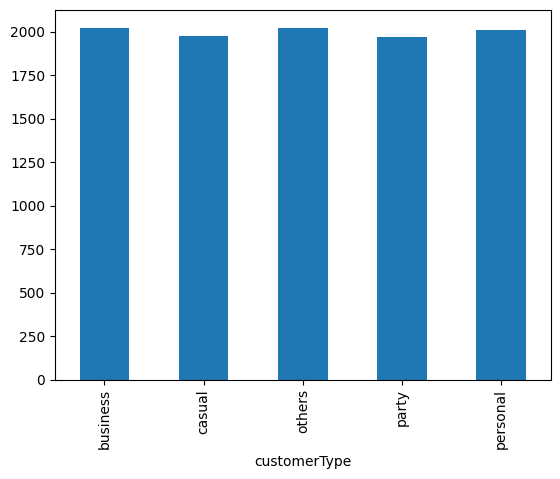

In [12]:
dfSales.groupby(["customerType"]).agg("order").count().plot.bar()

<Axes: xlabel='race'>

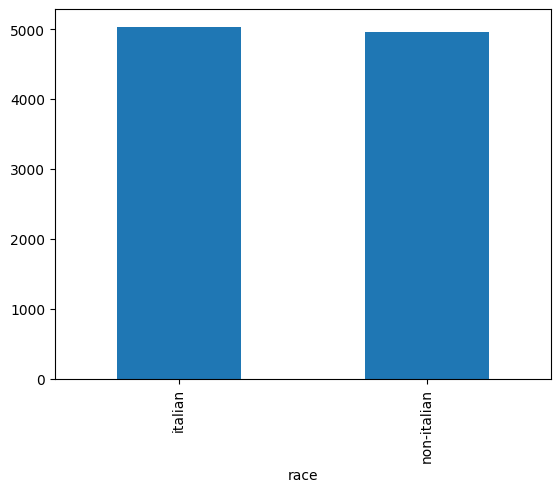

In [13]:
dfSales.groupby(["race"]).agg("order").count().plot.bar()

<Axes: xlabel='starter,specials,maincourse'>

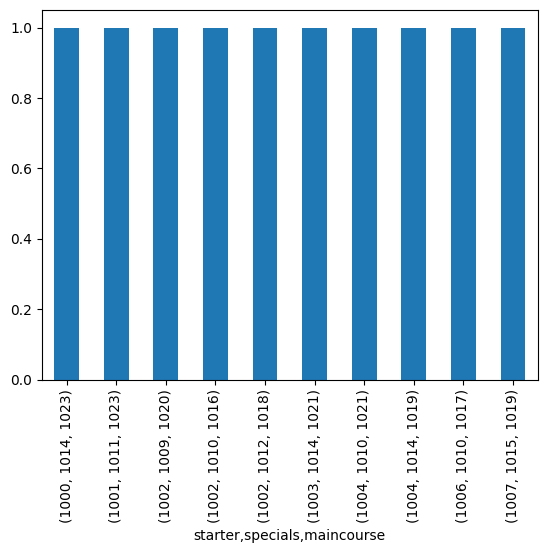

In [14]:
# take a sample of sales item
# plot starter, specials and maincourse counts in order
dfSales.sample(10).groupby(["starter","specials","maincourse"]).agg("order").count().plot.bar()

<Axes: xlabel='guest'>

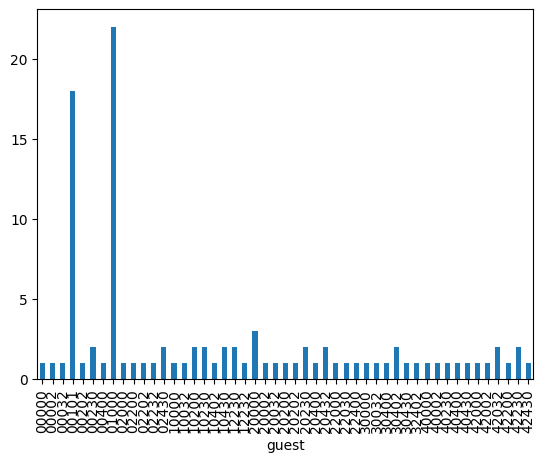

In [15]:
# this is opinionated dataset
# certain guest types prefer to order certain food
# we want our recommendation engine to learn this pattern and predict
dfML.sample(100).groupby(["guest"]).agg("order").count().plot.bar()

## Split order by items

so far, we are seeing starter, specials and maincourse as one order.
This approach is fine, if prediction goal is limited to find out one "preferred" order.

However, since we also need to find out recommendation relative to starter, specials and maincourse, we will need to split order in 3 rows.

for example, one order row, needs to be broken into 3 rows, with starter, specials and maincourse as individual rows.


In [16]:
dfSales.head(2)

,name,customerType,race,meal,weekday,holiday,starter,specials,maincourse,starter_desc,specials_desc,maincourse_desc,guest,order
0,Ruth Hoffman,business,non-italian,mid-day,False,True,1000,1008,1016,Carbonara Arancini,Spaghetti alla Carbonara,Aperitivo,12432,"[1000, 1008, 1016]"
1,Thomas Murillo,business,italian,dinner,False,False,1000,1008,1016,Carbonara Arancini,Spaghetti alla Carbonara,Aperitivo,10030,"[1000, 1008, 1016]"


In [17]:
dfML.shape, dfML.head(2)

((15000, 2),
    guest               order
 0  01000  [1007, 1015, 1023]
 1  01000  [1007, 1015, 1023])

In [18]:
dfML2 = dfML.copy()
dfML2 = dfML2.explode("order").reset_index().drop(columns="index")
dfML2.shape, dfML2.head(3)

((45000, 2),
    guest order
 0  01000  1007
 1  01000  1015
 2  01000  1023)

In [19]:
dfML3 = dfML2.groupby(["guest", "order"])["order"].count().reset_index(name="weight")
dfML3.head(2)

,guest,order,weight
0,00000,1000,10
1,00000,1001,10


## Prediction Goals

what are we trying to predict? Becuase, we inserted opinionated data previously, we will test same scenarios to confirm our understanding.

- for a single *italian* guest, visiting during weekday lunch time, what is best sellers as starter, maincourse and specials
- for a single *non-italian* guest, visiting during weekend dinner time, what is best sellers as starter, maincourse and specials
- for a single *italian* guest, visiting during weekday lunch time, what is best sellers as starter, maincourse and specials
- for a single *italian* guest, visiting during weekend dinner time, what is best sellers as starter, maincourse and specials
- for a family of 4 *italian*, visiting during weekend dinner time, what is best sellers as starter, maincourse and specials
- for a family of 4 *italian*, visiting during weekday dinner time, what is best sellers as starter, maincourse and specials
- for a family of 4 *italian*, visiting during weekend lunch time, what is best sellers as starter, maincourse and specials
- for a family of 4 *non-italian*, visiting during weekday lunch time, what is best sellers as starter, maincourse and specials

## Feature Engineering
---

- **Customer Name:** - *We will ignore name as these are fake names.* **what is in a name?** just an example, The "name" field is crucial in the Titanic survivor dataset as it can predict survival with 82% accuracy. For instance, females had a certain percent of survival rate on the Titanic, which can be inferred from their names. Thus, the "name" field provides valuable insights and predictions. Do NOT discard name as feature in real dataset.
- **Customer Race:** - provide valuable insight.
- **# of accompanying guest:** - important feature
- **day:** - check if is weekend, or holiday
- **time:** - check if brunch, lunch or dinner
- **food:** - food from foodItem List
- **qty:** - food quantity

There is no `Label` in this dataset, we can't do supervised ML. We need to build a Recommendation Engine.

## cold start

Recommender systems encounter a challenge called the "user cold-start problem," where it's difficult to provide tailored recommendations for users with minimal or no consumption history. This is because there's a lack of data to accurately model their preferences.

*It's acceptable to make no predictions when there's no data available for machine learning training.*

**Avoid making things up or hallucinating.**

Notify users when a recommended item has not been properly trained using machine learning.

In [46]:
# remove rows where # of interactions < 10
# this doesn't apply in this case, but in other real-life data set
# remove rows with fewer occurances

## feature strength

Let's tag those combinations (starter, special & maincourse) which are more popular than others and give each combination a strength score.

In [20]:
# smooth weights / strength score
import math

def smooth_weights(x):
    return math.log(1+x, 2)
    
dfML4 = dfML3.groupby(['guest', 'order'])['weight'].sum().apply(smooth_weights).reset_index()

dfML4.shape, dfML4.head(2)

((2886, 3),
    guest  order    weight
 0  00000   1000  3.459432
 1  00000   1001  3.459432)

## Train & Test data split

In [24]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(dfML4,
                                   stratify=dfML4['guest'], 
                                   test_size=0.20,
                                   random_state=42)

print('# Train set: %d' % len(train_df))
print('# Test set: %d' % len(test_df))

# Train set: 2308
# Test set: 578


## Evaluation criteria

Measuring the accuracy of a model is a challenging task.

*Below Evaluation is NOT to test model accuracy, it's to test how strong recommendation strength is.*

One approach is to analyze the accuracy of the model's predictions for a specific customer type, occasion, and day. We can predict which main course and special items a customer will choose, given that they have ordered a starter item.

This approach is analogous to using Top-N accuracy metrics, which assess the accuracy of the model's top recommendations for a user, relative to the items the user has interacted with in the test data.

*Although we have a clear understanding of our dataset, we will still need to manually evaluate the accuracy of our model. However, the code below can be used to assess the model's performance.*

In [48]:
#####################################
## Top-N accuracy metrics consts
# this code is way too complex for this simple task
# we will need to find a better way to evaulate model
#####################################
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

def get_items_interacted(guest, interactions_df):
    # Get the user's data and merge in the movie information.
    interacted_items = interactions_df.loc[guest]['order']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

class ModelEvaluator:

    def get_not_interacted_items_sample(self, guest, sample_size, seed=42):
        interacted_items = get_items_interacted(guest, interactions_full_indexed_df)
        all_items = set(articles_df['order'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, guest):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[guest]
        if type(interacted_values_testset['order']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['order'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['order'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(guest, 
                                               items_to_ignore=get_items_interacted(guest, 
                                                                                    interactions_train_indexed_df), 
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(guest, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['order'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['order'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, guest in enumerate(list(test_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, guest)  
            person_metrics['_person_id'] = guest
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()

## 1 - Popularity model

In [49]:
#Computes the most popular items
p_df = dfML4.groupby('order')['weight'].sum().sort_values(ascending=False).reset_index()
p_df.head(20)

# results must include these food items in top order because
# we created biased data on these food items
# o1 = [1007,1015,1023]
# o2 = [1001,1014,1017]

,order,weight
0,1017,430.323025
1,1015,425.827839
2,1004,423.024809
3,1000,420.675640
4,1007,420.196076
5,1014,419.894938
6,1005,417.440130
7,1003,417.042277
8,1018,416.896689
9,1001,416.839028


In [50]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['order'].isin(items_to_ignore)] \
                               .sort_values('weight', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'order', 
                                                          right_on = 'order')[['weight', 'order','starter_desc']]


        return recommendations_df
    
popularity_model = PopularityRecommender(dfML4, dfSales)


In [51]:
foodList.head(2)

,itemID,category,item
0,1000,starter,Carbonara Arancini
1,1001,starter,Chopped Italian Salad


In [52]:
###############################################################################
## PREDICION - 
## guest = 01000 =  single italian guest, visiting during weekday lunch time
###############################################################################
popularity_model.recommend_items("01000").merge(foodList, left_on='order', right_on='itemID')
# o1 = [1007,1015,1023]
# o2 = [1001,1014,1017]

# as you can see, model is predicting very accurately for a given guest type

,guest,order,weight,itemID,category,item
0,01000,1023,11.288289,1023,maincourse,Dolce
1,01000,1015,11.288289,1015,specials,Gelato
2,01000,1007,11.288289,1007,starter,Autumn Fritto Misto
3,00101,1017,11.288289,1017,maincourse,Antipasti
4,00101,1014,11.288289,1014,specials,Lasagne
5,00101,1001,11.288289,1001,starter,Chopped Italian Salad
6,30230,1022,4.523562,1022,maincourse,Formaggi e frutta
7,02430,1001,4.523562,1001,starter,Chopped Italian Salad
8,32002,1009,4.459432,1009,specials,Napoletana Pizza
9,20232,1008,4.459432,1008,specials,Spaghetti alla Carbonara


In [54]:
###################################
## this code auto evaluate model on Top-N accuracy metrics consts
## code has error
## debugging is required
###################################
# print('Evaluating Popularity recommendation model...')
# pop_global_metrics, test_df = model_evaluator.evaluate_model(popularity_model)
# print('\nGlobal metrics:\n%s' % pop_global_metrics)
# pop_detailed_results_df.head(10)

## 2 - Content based filtering

1. There are Two prevalent methods exist for constructing a recommendation system, although they may not appear optimal for a food item order recommendation engine. However, given that we aim to utilize this data to validate and apply learning to another dataset, it's worth examining and testing these approaches.

- Approach 2a - TF-IDF and Cosine similarity
- Approach 2b - GenAI RAG based approach


### Approach 2a - TF-IDF and Cosine similarity


In the field of information retrieval and NLPs, a widely used technique is TF-IDF, which transforms unstructured text into a vector format.

Each word in the text is assigned a specific position in the vector space, and its corresponding value indicates the word's relevance to the article. 

This conversion enables the computation of similarity between articles, as all items are represented in the same vector space.

In [55]:
dfSales

,name,customerType,race,meal,weekday,holiday,starter,specials,maincourse,starter_desc,specials_desc,maincourse_desc,guest,order
0,Ruth Hoffman,business,non-italian,mid-day,False,True,1000,1008,1016,Carbonara Arancini,Spaghetti alla Carbonara,Aperitivo,12432,"[1000, 1008, 1016]"
1,Thomas Murillo,business,italian,dinner,False,False,1000,1008,1016,Carbonara Arancini,Spaghetti alla Carbonara,Aperitivo,10030,"[1000, 1008, 1016]"
2,Sergio Garcia,others,italian,mid-day,False,True,1000,1008,1016,Carbonara Arancini,Spaghetti alla Carbonara,Aperitivo,40432,"[1000, 1008, 1016]"
3,Adam Mercer,personal,non-italian,lunch,False,False,1000,1008,1016,Carbonara Arancini,Spaghetti alla Carbonara,Aperitivo,02230,"[1000, 1008, 1016]"
4,Emily Weaver,others,non-italian,dinner,True,False,1000,1008,1016,Carbonara Arancini,Spaghetti alla Carbonara,Aperitivo,42000,"[1000, 1008, 1016]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Ryan Marsh,party,non-italian,mid-day,True,False,1007,1015,1023,Autumn Fritto Misto,Gelato,Dolce,22400,"[1007, 1015, 1023]"
9996,Amanda Weber,others,non-italian,mid-day,True,True,1007,1015,1023,Autumn Fritto Misto,Gelato,Dolce,42402,"[1007, 1015, 1023]"
9997,Jillian Bird,others,italian,lunch,False,True,1007,1015,1023,Autumn Fritto Misto,Gelato,Dolce,40232,"[1007, 1015, 1023]"
9998,Alex Cunningham,personal,non-italian,dinner,True,False,1007,1015,1023,Autumn Fritto Misto,Gelato,Dolce,02000,"[1007, 1015, 1023]"


In [82]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy

# this is not required as we are not dealing with engligh here
#Ignoring stopwords (words with no semantics) from English and Portuguese (as we have a corpus with mixed languages)
# stopwords_list = stopwords.words('english') + stopwords.words('portuguese')

#Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     # stop_words=stopwords_list
                            )

item_ids = dfSales['order'].tolist()
tfidf_matrix = vectorizer.fit_transform(dfSales['customerType'] + "" + dfSales['race'] + "" + dfSales['meal'])
# ignore weekday and holiday for now
# or later convert these values to text from bool
# tfidf_matrix = vectorizer.fit_transform(dfSales['customerType'] + "" + dfSales['race'] + "" + dfSales['meal'] + "" + dfSales['weekday'] + "" + dfSales['holiday'])

tfidf_feature_names = vectorizer.get_feature_names_out()
tfidf_matrix

<10000x45 sparse matrix of type '<class 'numpy.float64'>'
	with 26760 stored elements in Compressed Sparse Row format>

In [89]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = dfSales.loc[person_id]
    user_item_profiles = get_item_profiles(dfSales['order'])
    
    user_item_strengths = np.array(dfSales['order']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = dfSales[dfSales['order'] \
                                                   .isin(dfSales['order'])].set_index('guest')
    user_profiles = {}
    for person_id in dfSales.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, dfSales)
    return user_profiles

In [ ]:
user_profiles = build_users_profiles()
len(user_profiles)

myprofile = user_profiles[-1479311724257856983]
print(myprofile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles[-1479311724257856983].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

In [78]:
from sklearn.metrics.pairwise import cosine_similarity

class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['order', 'weight']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'order', 
                                                          right_on = 'order')[['weight', 'order']]


        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(dfML4)

In [ ]:
###############################################################################
## PREDICION - 
## guest = 01000 =  single italian guest, visiting during weekday lunch time
###############################################################################
content_based_recommender_model.recommend_items("01000").merge(foodList, left_on='order', right_on='itemID')
# o1 = [1007,1015,1023]
# o2 = [1001,1014,1017]

# as you can see, model is predicting very accurately for a given guest type

In [74]:
###################################
## this code auto evaluate model on Top-N accuracy metrics consts
## code has error
## debugging is required
###################################
# print('Evaluating Content-Based Filtering model...')
# cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)
# print('\nGlobal metrics:\n%s' % cb_global_metrics)
# cb_detailed_results_df.head(10)

### Approach 2b - GenAI RAG based approach

This approach is very effective and extremely popular.

Pro:
- great results
- very less development efforts.

Cons:
- expensive because an active subscriptions to following is required.
    - subscription to Open AI ChatGPT or Anthropic Claude Model
    - PineCone Vector Database or Databricks Vector RAG Database
    - Embedding Model (Voyage model="voyage-2" or OpenAI text-embedding-3-large)

In [ ]:
# # !pip install -U voyageai

# # Then, you can create a client object and start using it to embed your texts:
# import voyageai

# vo = voyageai.Client()
# # This will automatically use the environment variable VOYAGE_API_KEY.
# # Alternatively, you can use vo = voyageai.Client(api_key="<your secret key>")

# texts = ["Sample text 1", "Sample text 2"]

# result = vo.embed(texts, model="voyage-2", input_type="document")
# print(result.embeddings[0])
# print(result.embeddings[1])

# #####################################################################
# # now we have created tokens of text in equal chunks
# # we are ready to create embeddings and store into vector database
# # this is code to create embedding of our text
# #####################################################################

# import voyageai

# vo = voyageai.Client()

# # Embed the documents
# doc_embds = vo.embed(
#     df.text[:2].tolist(), model="voyage-2", input_type="document"
#     # first embedding only 2 rows
#     # change df.text[:2] to df.text to run it for all chunks
# ).embeddings

# print(result.embeddings[0])
# print(result.embeddings[1])

# #####################################################################
# # now since we have created embeddings of all our text
# # we will need to create embedding of our query
# # and then perform a similarity search to query our vector/text database
# #####################################################################

# query = "how are args and keyword arguments defined in python?"

# import numpy as np

# # Embed the query
# query_embd = vo.embed(
#     [query], model="voyage-2", input_type="query"
# ).embeddings[0]

# # Compute the similarity
# # Voyage embeddings are normalized to length 1, therefore dot-product
# # and cosine similarity are the same.
# # how to calculate distinace between embeddings
# similarities = np.dot(doc_embds, query_embd)

# retrieved_id = np.argmax(similarities)
# print(df.text.tolist()[retrieved_id])

## 3 - Collaborative based filtering

**Not Tested this approach, we should revisit this with production data.**

content-based + popularity approach is working well for our dataset.

## 4 - Hybrid Models

**Not Tested this approach, we should revisit this with production data.**

content-based + popularity approach is working well for our dataset.

## Model Comparison